Ben: A lot of unfamiliar packages here, more on the way. pipenv/virtual environments are your friend. A quick disclaimer that I am barely familiar with this domain of financial modeling, i can be very wrong in my understanding of things. i hope my code is readable.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from pandas_datareader import data as pdr
import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues
import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

In [20]:
yf.pdr_override() # for use with pandas-datareader, optional

# Data Sources/Exploration
## which stocks/tickers will we be looking at?
We've more or less arbitrarily settled on the current S&P 500 index, a popular choice.
## What data do we need, and where can we get it?
We need OHLC (open high low close) data, on a monthly and daily scale. Using yfinance, a module that basically scrapes the ya"hoo finance site for data on tickers, we can get most of what we need.
## 

In [21]:
ticker = pd.read_csv('ticker.csv')['Ticker']
tickers = ticker.to_list() # This is a list of all tickers in the SP500
tickers = [x.replace('.','-') for x in tickers] # yahoo has '-' instead of '.' for tickers, eg BRK.B
ticker.head()

0     AAPL
1     MSFT
2     AMZN
3       FB
4    GOOGL
Name: Ticker, dtype: object

In [22]:
# tickers

In [23]:
# sp_500 = {x:yf.Ticker(x) for x in tickers} # a dict of initialized yfinance tickers
# sp_500['AAPL'].history(start='2019-01-01', end='2020-12-31', interval='1mo')
# sp_500['AAPL'].history(start='2010-01-01', end='2020-12-31')

In [241]:
## below is how I got monthly and daily pandas dataframes of all stocks in one huge dict.  
monthly_sp500 = {}
for tkr in tickers: # run all 500 at your own risk, it takes a while lol
# for tkr in tickers[:10]:
    print('Grabbing ' + tkr + " data!")
    # monthly_sp500[tkr] = yf.Ticker(tkr).history(start='2010-01-01', end='2020-12-31', interval='1mo')
    monthly_sp500[tkr] = pdr.get_data_yahoo(tkr, start="2010-01-04", interval = "1mo").drop_duplicates()
    sleep(.1) # not planning on ddos-ing yahoo today
monthly_sp500['AAPL'] # take AAPL, for example; TODO deal with the pesky NaNs properly

ata!
[*********************100%***********************]  1 of 1 completed
Grabbing AJG data!
[*********************100%***********************]  1 of 1 completed
Grabbing FLT data!
[*********************100%***********************]  1 of 1 completed
Grabbing TTWO data!
[*********************100%***********************]  1 of 1 completed
Grabbing HSY data!
[*********************100%***********************]  1 of 1 completed
Grabbing CERN data!
[*********************100%***********************]  1 of 1 completed
Grabbing CDW data!
[*********************100%***********************]  1 of 1 completed
Grabbing FTNT data!
[*********************100%***********************]  1 of 1 completed
Grabbing OXY data!
[*********************100%***********************]  1 of 1 completed
Grabbing VTRS data!
[*********************100%***********************]  1 of 1 completed
Grabbing WST data!
[*********************100%***********************]  1 of 1 completed
Grabbing O data!
[*********************100

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10
...,...,...,...,...,...,...
2020-12-01,121.010002,138.789993,120.010002,132.690002,132.492020,2.322957e+09
2021-01-01,133.520004,145.089996,126.379997,131.960007,131.763107,2.240534e+09
2021-02-01,133.750000,137.880005,118.389999,121.260002,121.079071,1.833204e+09


In [243]:
monthly_sp500['MSFT']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-01,28.389999,29.030001,27.570000,28.670000,22.278278,1.074643e+09
2010-02-16,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-01,28.770000,30.570000,28.240000,29.290001,22.866486,1.110237e+09
2010-04-01,29.350000,31.580000,28.620001,30.540001,23.842352,1.319030e+09
2010-05-01,30.670000,31.059999,24.559999,25.799999,20.141876,1.720130e+09
...,...,...,...,...,...,...
2020-12-01,214.509995,227.179993,209.110001,222.419998,221.908905,5.948060e+08
2021-01-01,222.529999,242.639999,211.940002,231.960007,231.426987,6.480981e+08
2021-02-01,235.059998,246.130005,227.880005,232.380005,231.846024,4.909253e+08


In [26]:
daily_sp500 = {}
# for tkr in tickers:
for tkr in tickers[:10]: #this only gets the first 10 fyi
    print('Grabbing ' + tkr + " data!")
    # daily_sp500[tkr] = yf.Ticker(tkr).history(start='2010-01-01', end='2020-12-31', interval='1mo')
    daily_sp500[tkr] = pdr.get_data_yahoo(tkr,start="2010-01-01")
    sleep(.1)
daily_sp500['AAPL'] # take AAPL, for example

Grabbing AAPL data!
[*********************100%***********************]  1 of 1 completed
Grabbing MSFT data!
[*********************100%***********************]  1 of 1 completed
Grabbing AMZN data!
[*********************100%***********************]  1 of 1 completed
Grabbing FB data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOGL data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOG data!
[*********************100%***********************]  1 of 1 completed
Grabbing TSLA data!
[*********************100%***********************]  1 of 1 completed
Grabbing BRK-B data!
[*********************100%***********************]  1 of 1 completed
Grabbing JPM data!
[*********************100%***********************]  1 of 1 completed
Grabbing JNJ data!
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...
2021-03-01,123.750000,127.930000,122.790001,127.790001,127.790001,115998300
2021-03-02,128.410004,128.720001,125.010002,125.120003,125.120003,102015300
2021-03-03,124.809998,125.709999,121.839996,122.059998,122.059998,112430400


In [83]:
# imputed_aapl = imputed_aapl.set_index(monthly_sp500['AAPL'].index)

In [84]:
# len(imputed_aapl.loc[imputed_aapl.isna().any(axis=1)])/len(imputed_aapl) * 100 #percentage of missingness

In [244]:
# everything in one stupid large dataframe
sp500m = monthly_sp500[tickers[0]] # monthly
sp500m['Name'] = tickers[0]

sp500d = daily_sp500[tickers[0]] # daily
sp500d['Name'] = tickers[0]

# for tkr in tickers[1:10]:
for tkr in tickers[1:]:
    df1 = monthly_sp500[tkr] # monthly
    df1['Name'] = tkr
    # df.set_index(['Name','Date'],inplace=True)
    sp500m = sp500m.append(df1)

    # df2 = daily_sp500[tkr] # daily
    # df2['Name'] = tkr
    # # df.set_index(['Name','Date'],inplace=True)
    # sp500d = sp500d.append(df2)
sp500m

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...
2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS
2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS
2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS


In [190]:
sp500m.value_counts('Name')

Name
JNJ      180
JPM      180
MSFT     180
AAPL     172
GOOG     137
BRK-B    136
GOOGL    136
AMZN     135
TSLA     131
FB       107
dtype: int64

In [194]:
sp500m.groupby('Name').head(5)

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
2010-02-01,28.389999,29.030001,27.570000,28.670000,22.278278,1.074643e+09,MSFT
2010-02-16,NaN,NaN,NaN,NaN,NaN,NaN,MSFT
2010-03-01,28.770000,30.570000,28.240000,29.290001,22.866486,1.110237e+09,MSFT
2010-04-01,29.350000,31.580000,28.620001,30.540001,23.842352,1.319030e+09,MSFT


In [200]:
print(sp500m.shape,sp500d.shape)
sp500m

(82409, 7) (2812, 7)


,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...
2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS
2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS
2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS


In [245]:
# sp500m.to_csv('SP500_monthly.csv')
# sp500d.to_csv('SP500_daily.csv')
# df = pd.read_csv('SP500_monthly.csv').infer_objects().set_index('Name').dropna()
# df = pd.read_csv('SP500_monthly.csv').infer_objects().dropna()
df = sp500m.infer_objects().dropna().reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...,...
65437,2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS
65438,2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS
65439,2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS
65440,2021-03-01,23.209999,23.870001,22.389999,22.770000,22.770000,1.579400e+06,NWS


In [246]:
st = pd.to_datetime(df.Date.min())
et = pd.to_datetime(df.Date.max())
j=1
k=2
# the 'midpoints' for each observe and hold period. midpoint in this context is where we switch from the observation period len=j to the holding period len=k
j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS")
j_end.strftime("%Y-%m-%d").to_list()

['2010-05-01',
 '2010-11-01',
 '2011-05-01',
 '2011-11-01',
 '2012-05-01',
 '2012-11-01',
 '2013-05-01',
 '2013-11-01',
 '2014-05-01',
 '2014-11-01',
 '2015-05-01',
 '2015-11-01',
 '2016-05-01',
 '2016-11-01',
 '2017-05-01',
 '2017-11-01',
 '2018-05-01',
 '2018-11-01',
 '2019-05-01',
 '2019-11-01',
 '2020-05-01',
 '2020-11-01']

In [247]:
#df of just the midpoint dates for sanity check
df[df['Date'].isin(j_end.strftime("%Y-%m-%d").to_list())].groupby('Name').head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
9,2010-11-01,10.793571,11.475000,10.634286,11.112500,9.571903,9.508086e+09,AAPL
15,2011-05-01,12.490714,12.565357,11.765000,12.422500,10.700285,6.912060e+09,AAPL
21,2011-11-01,14.193214,14.571429,12.975714,13.650000,11.757608,8.963702e+09,AAPL
27,2012-05-01,20.889286,21.312857,18.649286,20.633215,17.772696,1.110635e+10,AAPL
...,...,...,...,...,...,...,...,...
65352,2013-11-01,17.870001,18.260000,17.000000,17.969999,16.540766,1.500440e+07,NWS
65358,2014-05-01,16.600000,17.650000,16.320000,16.590000,15.270526,1.192450e+07,NWS
65364,2014-11-01,15.020000,15.440000,14.340000,15.050000,13.853006,3.394880e+07,NWS
65370,2015-05-01,15.690000,16.170000,14.780000,14.950000,13.760961,2.324360e+07,NWS


In [248]:
# based on the midpoint, get the start point for each observe and hold period
j_start = j_end + pd.DateOffset(months=-j*3)
j_start.strftime("%Y-%m-%d").to_list()

['2010-02-01',
 '2010-08-01',
 '2011-02-01',
 '2011-08-01',
 '2012-02-01',
 '2012-08-01',
 '2013-02-01',
 '2013-08-01',
 '2014-02-01',
 '2014-08-01',
 '2015-02-01',
 '2015-08-01',
 '2016-02-01',
 '2016-08-01',
 '2017-02-01',
 '2017-08-01',
 '2018-02-01',
 '2018-08-01',
 '2019-02-01',
 '2019-08-01',
 '2020-02-01',
 '2020-08-01']

In [249]:
# based on the midpoint, get the end point for each observe and hold period
k_end = j_end + pd.DateOffset(months=k*3)
k_end.strftime("%Y-%m-%d").to_list()

['2010-11-01',
 '2011-05-01',
 '2011-11-01',
 '2012-05-01',
 '2012-11-01',
 '2013-05-01',
 '2013-11-01',
 '2014-05-01',
 '2014-11-01',
 '2015-05-01',
 '2015-11-01',
 '2016-05-01',
 '2016-11-01',
 '2017-05-01',
 '2017-11-01',
 '2018-05-01',
 '2018-11-01',
 '2019-05-01',
 '2019-11-01',
 '2020-05-01',
 '2020-11-01',
 '2021-05-01']

In [250]:
timedf = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects() # i put all this garbage in a handy function below
timedf

,j_start,midpoint,k_end
0,2010-02-01,2010-05-01,2010-11-01
1,2010-08-01,2010-11-01,2011-05-01
2,2011-02-01,2011-05-01,2011-11-01
3,2011-08-01,2011-11-01,2012-05-01
4,2012-02-01,2012-05-01,2012-11-01
5,2012-08-01,2012-11-01,2013-05-01
6,2013-02-01,2013-05-01,2013-11-01
7,2013-08-01,2013-11-01,2014-05-01
8,2014-02-01,2014-05-01,2014-11-01
9,2014-08-01,2014-11-01,2015-05-01


## ^^^let me know if this timedf time table is useful or not. I wanted an easy way to organize time. we can very easily switch it over to getting that midpoint value instead

In [251]:
def generate_timetable(j=1, k=2):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    
    j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(months=-j*3) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(months=k*3) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k
timedf, j, k = generate_timetable()
timedf

,j_start,midpoint,k_end
0,2010-02-01,2010-05-01,2010-11-01
1,2010-08-01,2010-11-01,2011-05-01
2,2011-02-01,2011-05-01,2011-11-01
3,2011-08-01,2011-11-01,2012-05-01
4,2012-02-01,2012-05-01,2012-11-01
5,2012-08-01,2012-11-01,2013-05-01
6,2013-02-01,2013-05-01,2013-11-01
7,2013-08-01,2013-11-01,2014-05-01
8,2014-02-01,2014-05-01,2014-11-01
9,2014-08-01,2014-11-01,2015-05-01


In [252]:
df['Date']

0       2010-02-01
1       2010-03-01
2       2010-04-01
3       2010-05-01
4       2010-06-01
           ...    
65437   2020-12-01
65438   2021-01-01
65439   2021-02-01
65440   2021-03-01
65441   2021-03-05
Name: Date, Length: 65442, dtype: datetime64[ns]

In [253]:
midpoint = timedf.iloc[0].midpoint

In [254]:
def get_j_df(id=-1, midpoint=None, j=1):
    '''this should spit out a dataframe of data in the observational period j given specific id or midpoint value. 
    if unspecified it throws all of them at you with an extra identifying column "periods"'''
    if (id==-1): # not really sure why we need this but ill include it. this adds a sector column to the data for future filtering purposes if needed
        df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
        for i in timedf.index: 
            # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
            df_ = df[(timedf.iloc[i].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].midpoint)] # gets dates btw start and midpt
            df_['period'] = i
            df_i = pd.concat([df_i, df_])

        return df_i
    if (midpoint):
        start_time = midpoint + pd.DateOffset(months=-j*3)
        print('given ', midpoint.strftime("%Y-%m-%d"), ', getting range ', start_time.strftime("%Y-%m-%d"),midpoint.strftime("%Y-%m-%d"))

        return df[(start_time <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= midpoint)]
    return df[(timedf.iloc[id].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].midpoint)] # gets dates btw start and midpt from table
df0 = get_j_df(midpoint=midpoint, j=j)
df0

,Date,Open,High,Low,Close,Adj Close,Volume,Name,period
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL,0
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL,0
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL,0
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL,0
135,2010-02-01,28.389999,29.030001,27.570000,28.670000,22.278278,1.074643e+09,MSFT,0
...,...,...,...,...,...,...,...,...,...
65342,2020-11-01,12.410000,15.035000,12.360000,14.550000,14.550000,7.947709e+07,UA,21
65433,2020-08-01,12.790000,15.550000,12.680000,15.070000,14.970856,8.911600e+06,NWS,21
65434,2020-09-01,15.010000,15.700000,13.690000,13.980000,13.888026,1.345070e+07,NWS,21
65435,2020-10-01,13.970000,14.610000,12.680000,13.020000,13.020000,8.181500e+06,NWS,21


In [255]:
get_j_df(-1)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,period
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL,0
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL,0
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL,0
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL,0
135,2010-02-01,28.389999,29.030001,27.570000,28.670000,22.278278,1.074643e+09,MSFT,0
...,...,...,...,...,...,...,...,...,...
65342,2020-11-01,12.410000,15.035000,12.360000,14.550000,14.550000,7.947709e+07,UA,21
65433,2020-08-01,12.790000,15.550000,12.680000,15.070000,14.970856,8.911600e+06,NWS,21
65434,2020-09-01,15.010000,15.700000,13.690000,13.980000,13.888026,1.345070e+07,NWS,21
65435,2020-10-01,13.970000,14.610000,12.680000,13.020000,13.020000,8.181500e+06,NWS,21


In [256]:
# we can get these ordered based on the timedf table index as well
get_j_df(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
6,2010-08-01,9.301429,9.438571,8.412857,8.682143,7.478480,9.589121e+09,AAPL
7,2010-09-01,8.838214,10.526071,8.795714,10.133929,8.728997,1.184992e+10,AAPL
8,2010-10-01,10.219643,11.392857,9.920357,10.749286,9.259040,1.223458e+10,AAPL
9,2010-11-01,10.793571,11.475000,10.634286,11.112500,9.571903,9.508086e+09,AAPL
141,2010-08-01,25.990000,26.379999,23.320000,23.469999,18.405535,1.279372e+09,MSFT
...,...,...,...,...,...,...,...,...
65026,2010-11-01,5.868750,7.336250,5.731250,7.216250,7.216250,1.164432e+08,UAA
65158,2010-08-01,25.665348,26.324112,21.923584,22.266140,14.402317,9.929796e+07,XRX
65159,2010-09-01,22.661398,28.036892,22.635046,27.272726,17.640709,1.052086e+08,XRX
65160,2010-10-01,27.430830,30.909092,27.140976,30.830040,20.023676,1.038929e+08,XRX


In [257]:
print(get_k_df(0).Date.unique()) #sanity checking, hey it works
print(len(get_k_df(0).Name.unique())) #sanity checking, here i learned that we have 505 tickers

['2010-05-01T00:00:00.000000000' '2010-06-01T00:00:00.000000000'
 '2010-07-01T00:00:00.000000000' '2010-08-01T00:00:00.000000000'
 '2010-09-01T00:00:00.000000000' '2010-10-01T00:00:00.000000000'
 '2010-11-01T00:00:00.000000000']
454


In [258]:
len(tickers) # read above

505

In [259]:
def get_k_df(id=-1, midpoint=None, k=k):
    '''this should spit out a dataframe of data in the holding period k given specific id or midpoint value. 
    if unspecified it throws all of them at you with an extra identifying column "periods"'''
    if (id==-1): # we can decide if this is useful later this adds a sector column to the data for future filtering purposes if needed
        df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
        for i in timedf.index: 
            # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
            df_ = df[(timedf.iloc[i].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].k_end)] # gets dates btw midpt and end
            df_['period'] = i
            df_i = pd.concat([df_i, df_])

        return df_i
    if (midpoint):
        end_time = midpoint + pd.DateOffset(months=k*3)
        print('given ', midpoint.strftime("%Y-%m-%d"), ', getting range ', midpoint.strftime("%Y-%m-%d"), end_time.strftime("%Y-%m-%d"))

        return df[(midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= end_time)]
    return df[(timedf.iloc[id].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].k_end)] # gets dates btw midpt and end
get_k_df(midpoint=midpoint)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,period
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL,0
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL,0
5,2010-07-01,9.082143,9.499643,8.557143,9.187500,7.913781,1.566970e+10,AAPL,0
6,2010-08-01,9.301429,9.438571,8.412857,8.682143,7.478480,9.589121e+09,AAPL,0
7,2010-09-01,8.838214,10.526071,8.795714,10.133929,8.728997,1.184992e+10,AAPL,0
...,...,...,...,...,...,...,...,...,...
65437,2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS,21
65438,2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS,21
65439,2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS,21
65440,2021-03-01,23.209999,23.870001,22.389999,22.770000,22.770000,1.579400e+06,NWS,21


In [260]:
get_k_df(0)


,Date,Open,High,Low,Close,Adj Close,Volume,Name
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
5,2010-07-01,9.082143,9.499643,8.557143,9.187500,7.913781,1.566970e+10,AAPL
6,2010-08-01,9.301429,9.438571,8.412857,8.682143,7.478480,9.589121e+09,AAPL
7,2010-09-01,8.838214,10.526071,8.795714,10.133929,8.728997,1.184992e+10,AAPL
...,...,...,...,...,...,...,...,...
65157,2010-07-01,21.238472,25.981556,20.210804,25.665348,16.601019,1.537455e+08,XRX
65158,2010-08-01,25.665348,26.324112,21.923584,22.266140,14.402317,9.929796e+07,XRX
65159,2010-09-01,22.661398,28.036892,22.635046,27.272726,17.640709,1.052086e+08,XRX
65160,2010-10-01,27.430830,30.909092,27.140976,30.830040,20.023676,1.038929e+08,XRX


In [261]:
get_j_df(0)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
135,2010-02-01,28.389999,29.030001,27.570000,28.670000,22.278278,1.074643e+09,MSFT
...,...,...,...,...,...,...,...,...
65020,2010-05-01,4.250000,4.391250,3.640000,4.211250,4.211250,1.722504e+08,UAA
65152,2010-02-01,23.056652,24.769432,21.607378,24.690382,15.821362,1.179282e+08,XRX
65153,2010-03-01,24.716734,26.798420,24.716734,25.691700,16.463001,1.079048e+08,XRX
65154,2010-04-01,25.849802,30.882740,25.770752,28.722004,18.486734,1.574390e+08,XRX


In [278]:
timedf,j,k = generate_timetable(j=3, k=2)

In [294]:
df0 = get_j_df(0).set_index('Name')
# df0 = df0.set_index('Name')


df0['pct_change'] = df0['Adj Close'].groupby('Name').pct_change()
df0['cum_return'] = (df0['pct_change']+1).groupby('Name').cumprod().fillna(1)
df0['adj_close_shifted'] = df0['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
df0['adj_change'] = df0['Adj Close']/df0['adj_close_shifted'] #.bfill(0) 
df0[:15]
# how to calculate lagged return? get cumulative returns and then lag it by j quarters

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,
AAPL,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,NaN,1.000000,NaN,NaN
AAPL,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,0.148470,1.148470,NaN,NaN
AAPL,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,0.111022,1.275975,NaN,NaN
AAPL,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,-0.016125,1.255401,6.294721,1.255401
AAPL,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,-0.020827,1.229255,7.229299,1.070341
AAPL,2010-07-01,9.082143,9.499643,8.557143,9.187500,7.913781,1.566970e+10,0.022741,1.257209,8.031907,0.985293
AAPL,2010-08-01,9.301429,9.438571,8.412857,8.682143,7.478480,9.589121e+09,-0.055005,1.188056,7.902396,0.946356
AAPL,2010-09-01,8.838214,10.526071,8.795714,10.133929,8.728997,1.184992e+10,0.167215,1.386717,7.737815,1.128096
AAPL,2010-10-01,10.219643,11.392857,9.920357,10.749286,9.259040,1.223458e+10,0.060722,1.470921,7.913781,1.169989


In [312]:
df0.index.unique()

Index(['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B', 'JPM', 'JNJ',
       'NVDA',
       ...
       'NOV', 'LEG', 'RL', 'UNM', 'FLS', 'HFC', 'GPS', 'SLG', 'UAA', 'XRX'],
      dtype='object', name='Name', length=454)

In [322]:
df.Name.unique()[np.isin(df.Name.unique(),df0.index, invert=True)]

array(['FB', 'PYPL', 'ABBV', 'NOW', 'ZTS', 'GM', 'TWTR', 'HCA', 'DOW',
       'APTV', 'IQV', 'INFO', 'PSX', 'CTVA', 'MPC', 'HLT', 'CARR', 'KMI',
       'FRC', 'ETSY', 'KEYS', 'OTIS', 'ENPH', 'FTV', 'KHC', 'FLT', 'CDW',
       'SYF', 'CTLT', 'QRVO', 'PAYC', 'HPE', 'CFG', 'XYL', 'AMCR', 'ANET',
       'IR', 'FBHS', 'WRK', 'LW', 'FANG', 'FOXA', 'ALLE', 'NWSA', 'NLSN',
       'NCLH', 'HII', 'FOX', 'VNT', 'UA', 'NWS'], dtype=object)

In [326]:
monthly_sp500['PYPL'].head() # TODO we should write about some of the issues of yahoofinance as a datasource, that should be sufficient

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2015-08-01,39.250000,39.910000,30.000000,35.000000,35.000000,246871400,PYPL
2015-09-01,34.150002,35.459999,30.299999,31.040001,31.040001,199174100,PYPL
2015-10-01,30.820000,36.650002,30.750000,36.009998,36.009998,197230400,PYPL
2015-11-01,35.580002,38.520000,34.500000,35.259998,35.259998,197878100,PYPL
2015-12-01,35.410000,37.680000,33.849998,36.200001,36.200001,156937600,PYPL


In [306]:
features = df0.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False)
features

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,
NFLX,2010-11-01,24.850000,29.542856,23.367144,29.414286,29.414286,7.496153e+08,0.186265,3.117336,17.931429,1.640376
LVS,2010-11-01,46.349998,55.470001,44.099998,50.080002,33.399349,9.013144e+08,0.091543,3.011427,18.893837,1.767738
URI,2010-11-01,18.980000,20.770000,18.719999,19.620001,19.620001,2.857960e+07,0.044172,2.598676,11.250000,1.744000
CMG,2010-11-01,211.889999,262.769989,209.000000,258.489990,258.489990,2.046980e+07,0.229675,2.468628,150.830002,1.713784
FFIV,2010-11-01,117.980003,136.000000,112.099998,131.880005,131.880005,4.788060e+07,0.120476,2.363441,87.430000,1.508407
...,...,...,...,...,...,...,...,...,...,...,...
BLK,2010-11-01,171.740005,174.470001,161.529999,163.000000,123.415390,5.091100e+07,-0.046729,0.758340,106.721397,1.156426
ISRG,2010-11-01,88.080002,93.580002,82.016670,86.763336,86.763336,3.013560e+07,-0.010116,0.749813,88.343330,0.982115
STX,2010-11-01,14.820000,15.320000,13.150000,13.410000,8.175142,2.739812e+08,-0.088375,0.673531,6.181654,1.322485


In [336]:
# this calculates the winner and loser tickers given n
n = 10
def get_percents(n):
    return features.shape[0]//n+1
winner_tickers = features[:get_percents(n)].index
winner_tickers

Index(['NFLX', 'LVS', 'URI', 'CMG', 'FFIV', 'UAA', 'CRM', 'AKAM', 'TMUS',
       'ULTA', 'FTNT', 'IPGP', 'TSLA', 'BKNG', 'CMI', 'PXD', 'NTAP', 'AIG',
       'SWKS', 'ILMN', 'LYB', 'KMX', 'AAP', 'LB', 'UAL', 'BWA', 'WYNN', 'ALK',
       'TPR', 'AZO', 'TSCO', 'PVH', 'CTXS', 'ALXN', 'PCAR', 'ORLY', 'AAL',
       'AME', 'AAPL', 'CAT', 'YUM', 'AMZN', 'DLTR', 'MTD', 'EXPD', 'ALB'],
      dtype='object', name='name')

In [337]:
loser_tickers = features[-get_percents(n):].index
loser_tickers

Index(['VTRS', 'CAG', 'ANTM', 'EA', 'CBOE', 'LMT', 'JPM', 'MSFT', 'NRG', 'WHR',
       'ABT', 'NVR', 'DGX', 'COG', 'MS', 'V', 'BAX', 'DXC', 'WDC', 'IRM',
       'ZBH', 'NVDA', 'TFX', 'MAS', 'HPQ', 'SCHW', 'BSX', 'LYV', 'TFC', 'EQIX',
       'DHI', 'VRTX', 'PBCT', 'MU', 'ADBE', 'RF', 'MPWR', 'CSCO', 'MDT',
       'LDOS', 'GILD', 'BLK', 'ISRG', 'STX', 'BAC', 'PHM'],
      dtype='object', name='name')

In [366]:
# equally weight
weights = np.ones(get_percents(n))/(get_percents(n))

In [374]:
winner_df0 = df0.loc[winner_tickers.to_list()]
winner_df0 = winner_df0.pivot_table(index='date',columns='name')['pct_change'].fillna(0) # 
winner_df0
winner_df0.dot(weights) # gives us the percent change of the portfolios 

date
2010-02-01    0.000000
2010-03-01    0.116996
2010-04-01    0.103751
2010-05-01   -0.020289
2010-06-01   -0.044979
2010-07-01    0.116637
2010-08-01   -0.003548
2010-09-01    0.168566
2010-10-01    0.088689
2010-11-01    0.094784
dtype: float64

In [378]:
(winner_df0.dot(weights)+1).cumprod() - 1

date
2010-02-01    0.000000
2010-03-01    0.116996
2010-04-01    0.232886
2010-05-01    0.207872
2010-06-01    0.153543
2010-07-01    0.288089
2010-08-01    0.283519
2010-09-01    0.499877
2010-10-01    0.632900
2010-11-01    0.787674
dtype: float64

In [371]:
# call the returns of all the winner tickers
ret = pdr.get_data_yahoo(tickers = winner_tickers.to_list(), start="2010-02-01", interval = "1mo")['Adj Close'].pct_change()#.dropna()
ret.dot(weights)

[*********************100%***********************]  46 of 46 completed


Date
2010-02-01         NaN
2010-02-17         NaN
2010-03-01         NaN
2010-04-01         NaN
2010-05-01         NaN
                ...   
2021-01-01    0.005608
2021-02-01    0.087967
2021-02-08    0.000000
2021-03-01   -0.012853
2021-03-05    0.018136
Length: 191, dtype: float64

In [379]:
loser_df0 = df0.loc[loser_tickers.to_list()]
loser_df0 = loser_df0.pivot_table(index='date',columns='name')['pct_change'].fillna(0) # 
# winner_df0
loser_df0.dot(weights) # gives us the percent change of the portfolios 

date
2010-02-01    0.000000
2010-03-01    0.036022
2010-04-01    0.001885
2010-05-01   -0.099521
2010-06-01   -0.092631
2010-07-01    0.020081
2010-08-01   -0.085368
2010-09-01    0.090408
2010-10-01    0.008168
2010-11-01   -0.028242
dtype: float64

In [380]:
(loser_df0.dot(weights)+1).cumprod() - 1

date
2010-02-01    0.000000
2010-03-01    0.036022
2010-04-01    0.037975
2010-05-01   -0.065326
2010-06-01   -0.151906
2010-07-01   -0.134875
2010-08-01   -0.208729
2010-09-01   -0.137191
2010-10-01   -0.130144
2010-11-01   -0.154711
dtype: float64

this is us selecting winners and losers based on j, and then 

df0 df0_hold
df0
 winners and losers
 winnes are gonna wion
 losers are gonna losers
 1
 -1
 will winners for a certain buy and hold not win?
 will losers not lose?
 we are trying to be correct about it
 lagged returns to make statistical observations about an actual positive or negative return?
 is the paper just a guide?

paper used a single factor logisti regression model 
dependent variable was whether a momentum portfolio would actually be good.

in the following time period, which is the best strategy to make?


what portfolio? we have momentum and reversal. choose which one to make at certain times. 
buy and hold random stocks? is it making predictions on 

when you do simple buy and hold?
in the first paper ,a no effect? if both are going down we just sell and wait.
it would e super cool to see the evolution of the portfolios over the time period.
its a machine learning problem because we are making decisions to maximize profitability and cutting down on drawdown.

testing its performance on volatile market periods
    2008, 2012, 2020
its a strategy informed on a prediction task.

In [ ]:
df0.groupby('Name')

In [150]:
def create_portfolio(tickerlist):
    '''used to group tickers into respective momentum, reversal, etc groups'''
    return tickerlist # dummy

def get_winners(hold_df, n=10):
    """given hold df, calculate cumulative lagged return and select winners"""
    

stocks in ascending order, based on simple returns on the previous j quarters lagged returns
j=4: calculate 1-4 quarter lagged returns
for every k, go through all possible j's. j*k possibilities
predict positive or negative based on returns.

In [104]:
# mapping j period, looking at the data at a certain j, cumulative product. worrying about positions since we have the times,
# we would have needed percentage of change and calculate cumulative product and have that lagged return, that lagged return, we had lagged return from j so what is a loser exactly.
# amir asks if the paper calcualtes the j lag return and then j = lag and then for that j, between the 500 we fidn the top n winners and n losers and then put them into respective groups
# check out link amir sent
# getting lagged values iteratively 
# we would just need to get j in this case so it would be over the period the trailing window size. we would have to worry about defining  what one step is.


# TODO questions I would like to ask: for k holding period, do we just want to get the last value as a label, or pull all the data ahead?
# how are we training, exactly? our current abstraction is kind of getting k and calculating their features at once... are we looking at patterns in the different groups?



## ----prototyping below----

In [117]:
aapl = imputed_aapl # take a look at apple again, this time with no nulls (dont know how to deal with them help)
aapl.dropna().head()

,date,open,high,low,close,adj_close,volume
Name,,,,,,,
AAPL,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10
AAPL,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10
AAPL,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10
AAPL,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10
AAPL,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10


In [118]:
from sklearn.impute import KNNImputer

def effect(x):
    if( x < 0.0 ):
        return "Reversal"
    elif(x > 0.0):
        return "Momentum"
    else:
        return "None"
    


## shamelessly stolen code, still trying to comprehend what wizardry is going on in here
dfs = []
k = 4
# imputer = KNNImputer(n_neighbors = 2)
for ticker in tickers[:10]:
    print('Grabbing ' + ticker + " data!")
    curr_df = pdr.get_data_yahoo(ticker, start="2009-12-01", interval = "1mo")
    if(curr_df.empty):
        print('Failed to get ' + ticker + ' stock data!')
        continue
    
    #imputed_df = imputer.fit_transform(curr_df)
    #imputed_df = pd.DataFrame(imputed_df,columns=['Open','High','Low','Close','Adj Close','Volume'])
    #imputed_df = imputed_df.set_index(curr_df.index)
    
    
    curr_df = curr_df.dropna()
    #imputed_df['Name'] = ticker
    curr_df['Name'] = ticker
    # curr_df = imputed_df
    print(curr_df.isna().sum())
    curr_df = curr_df.reset_index()
    curr_df.set_index(['Name','Date'],inplace=True)
    curr_df = curr_df[~curr_df.index.duplicated(keep='first')]
    obs_df = (curr_df.reset_index(level=[0])
              ['Adj Close'].resample(str(k) + 'M').first().ffill().pct_change()[1:]).to_frame()
    obs_df.rename(columns={'Adj Close':'Adj Close %Change'},inplace=True)
    obs_df['Name'] = ticker
    obs_df = obs_df.reset_index()
    obs_df.set_index(['Name','Date'],inplace=True)
    obs_df['Cum Returns'] = (obs_df['Adj Close %Change'] + 1).groupby('Name').cumprod()
    obs_df['Effect'] = obs_df['Adj Close %Change'].apply(effect)
    dfs.append(obs_df)
    curr_df = None
    obs_df = None

Grabbing AAPL data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing MSFT data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing AMZN data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing FB data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing GOOGL data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume   

<AxesSubplot:>

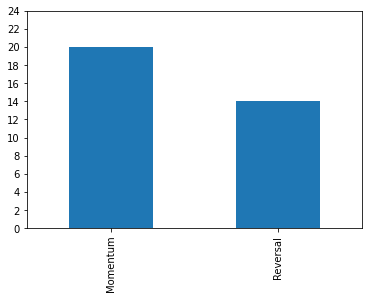

In [119]:
dfs[8]['Effect'].value_counts().plot(kind='bar',yticks=range(0,25,2))

In [299]:
dfs[0]

Adj Close %Change  Cum Returns    Effect
Name Date                                                
AAPL 2010-04-30          -0.088597     0.911403  Reversal
     2010-08-31           0.337499     1.219001  Momentum
     2010-12-31           0.104601     1.346510  Momentum
     2011-04-30           0.195841     1.610212  Momentum
     2011-08-31           0.025080     1.650595  Momentum
     2011-12-31           0.096283     1.809520  Momentum
     2012-04-30           0.197104     2.166184  Momentum
     2012-08-31           0.265620     2.741565  Momentum
     2012-12-31           0.159649     3.179254  Momentum
     2013-04-30          -0.314090     2.180682  Reversal
     2013-08-31          -0.006891     2.165654  Reversal
     2013-12-31           0.074143     2.326222  Momentum
     2014-04-30           0.056156     2.456854  Momentum
     2014-08-31           0.272052     3.125246  Momentum
     2014-12-31           0.125934     3.518823  Momentum
     2015-04-30           0.167921     4.109707  Momentum
     2015-08-31           0.116372     4.587962  Momentum
     2015-12-31          -0.145977     3.918224  Reversal
     2016-04-30          -0.113720     3.472643  Reversal
     2016-08-31           0.031455     3.581876  Momentum
     2016-12-31           0.145148     4.101777  Momentum
     2017-04-30           0.078930     4.425530  Momentum
     2017-08-31           0.264296     5.595179  Momentum
     2017-12-31           0.017046     5.690552  Momentum
     2018-04-30           0.090267     6.204220  Momentum
     2018-08-31           0.120658     6.952811  Momentum
     2018-12-31           0.216917     8.460994  Momentum
     2019-04-30          -0.260119     6.260129  Reversal
     2019-08-31           0.056362     6.612960  Momentum
     2019-12-31           0.289123     8.524918  Momentum
     2020-04-30           0.386075    11.816176  Momentum
     2020-08-31           0.029675    12.166815  Momentum
     2020-12-31           0.463583    17.807140  Momentum
     2021-04-30           0.141418    20.325398  Momentum

In [296]:
aapl.Date

AttributeError: 'DataFrame' object has no attribute 'Date'

In [ ]:
new_df = pd.merge_asof(dfs[0].reset_index(),aapl,on='Date')
new_df['Name'] = 'AAPL'
new_df.set_index(['Name','Date'],inplace=True)
new_df = new_df[~new_df.index.duplicated(keep='first')]
new_df

In [298]:
import pandas_ta as ta
new_df.ta.cores = 7
new_df.ta.sma(length=8, append=True)
new_df.ta.rsi(append=True)
new_df.ta.cci(length=8, append=True)
new_df['return std'] = new_df['Cum Returns'].rolling(2).std()
new_df.ta.willr(length=k/2, append=True)
new_df.ta.roc(length=k/2,append=True)
new_df.ta.ema(append=True)
new_df.ta.pdist(append=True)
new_df.ta.variance(length=4,append=True)
new_df.ta.psar(append=True)
new_df = new_df.join(pd.get_dummies(new_df.Effect, prefix='Effect')) #one hot
new_df

NameError: name 'new_df' is not defined

In [ ]:
import seaborn as sns

corr = new_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="PuBuGn", vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
new_df

In [ ]:
# def K_ranking(ticker_df):
def K_ranking(start_time, end_time):
    '''given a time range, this reads in OHLC data of the s&p500 and converts it into usable features.'''
    

# Modeling:
Below we start to really look at feature engineering, not much here yet

In [ ]:
# pd.read_csv('constituent_performance_4_months.csv')

In [ ]:
# momentum/ model: given a huge dataset with daily/monthly data, we determine in an initial period J to find which tickers do the best/worst, 

## ---notes below---

# For the momentum analysis portion:
The way we plan to proceed for now is to give each stock in our index (sp500) equal weights, in a sense, then rank them by some criteria on how well they are performing. we will adopt the observe J and hold K strategy as detailed in the paper, in which there is an observatory period of J quarters/months/days and a holding period of K quarters/months/days (Ben: idk, j might be able to overlap with k, we can do a lot with how we implement it). In short, we classify in the J period whether a particular ticker would be best treated with a momentum or reversal strategy, or some other. The classification task here is thus presented.

momentum strategy: buy/give heavier weights over time to well performing stocks, as we assume they will continue to get better as per our understanding of momentum

reversal strategy: Amir proposed we short underperforming stocks. This strategy we adopt *might* actually be different from what the paper is proposing, which is to buy and hold underperforming stocks as we predict it to rebound (Ben: fact check me pls).

stocks in between: dont buy them, or leave them as they are...? feel free to share your own thoughts.

# For the modeling portion: 
a lot still left untouched, ill think a bit harder about it tmr ...
we want 3 models to do this kind of momentum analysis algorithmically vs manually, and pit it against a baseline of a simple buy and hold strategy. The parameters will come from a wealth of technical analysis (read: all the fancy hard to understand financial forecasting stuff) libraries already available (we probably wont be making most of them, beyond the simple stuff) but we do have a deadline to keep in mind.

momentum groups have positive trensds, high return rates, 

reversal groups are stocks taht are losing. 
dynamically managing the 500 tickers in s&p.

hwo do we predict who is going into momentum group at t+k, and how accurate can we be?
based on the pricing trends, who will be in reversal and who will be in momentum?
    a lot of room to work with
bactesting takes our predictions and our model trained to figure out how to weight the positions of the stocks, we would take that strategy and test it on historical data

we would have a lot to talk about in terms of a paper, how to improve, what not to notice
how it could be used in the real world market

do we want to create our own feature on which ticker is profitable, or 
- returns? predicting reurns over a certain period\\
- the momentum to reversal ratio for a particular 
- more categorical features interpreted from indicators
if we could answer these questions, how to implement above
predictions on who goes where, then we can find out which features can increase accuracy over time, then weights, risk parameter, where the algo tries to place the stocks momentum and reversal groups and then it meets the parameter that we feed
how do I predict, say, can we predict the possible return and then see, based on that,..
there are certain indicators 
moving averages, where they change is a trend reversal indicate where and when that happens
if we need more features

waht would be a good starting point for us to start on?
- creating features? familiarizing ourselgves with this notebook
- we bought here and held there\
- maybe correlation analysis? taking old data and shiftiing it around to create and make it as accurate as possible for one of those and then figuring out which one of these affect accuracy of who goes in what group.
tldr the sooner we play with the features bnetter 
who is in momentum who is in reversal based on certain criteria?
for momentum and reversal, we are predicting return, get rmse beneath 80, and then visualize how it places and then prefirmance. start iterating on that part. cumulative returns vs actual returns
creating better features?
tuning parameters to modify the suggestion you would give based on momentum group.
no effect is that it dont make it int
we have many variables to compare the two. lower profiitability and higher rate. if it kept your risk constrained and you still had a significant strategy



analyze at j, hold for k. 
evaluating when it hits the lowest...?




so we have stocks, are we predicting profitability? -its not a difficult question to ask. we are predicting 

shweta as a clasirifation problem, momentum nad reversal. 
if we went back to momentum and reversal?
- with these, can we predict return? pick a momentum or reversal group 
we label with momentum and reversal. say we have a collection, and a group at certain points. predict return? if you were to hold them for a time. use calculations for holding, having a certain period  and hold? for a certain amount. eg 2010 to 2015, we have all the return data, take the 

could we create a concrete quesiton
xgd regressor
> check out the moethodology portion